In [1]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from itertools import product
import random
import seaborn as sns

In [2]:
df = pd.read_csv('../data/spotify_dataset.csv', usecols=range(4), lineterminator='\n', header=0)

In [3]:
df.columns = [x.replace('"', '').lstrip() for x in df.columns]

In [4]:
playlists = df['playlistname'].unique()
print('Number of Playlists:', len(playlists))
print('Number of Artists:', len(df['artistname'].unique()))

Number of Playlists: 161530
Number of Artists: 290002


#### Problem:
- Networkx takes too much time to load up a graph with all the data <br>
- In ~5 min we can retrieve 2000 artist genres


#### Potential Solution:
- Sample 1,000 playlists
- See if there is a sufficient amount of artists and playlist appearances

In [5]:
np.random.seed(0)
sample_playlists = np.random.choice(playlists, 5000, replace=False)
sampled_df = df[df['playlistname'].isin(sample_playlists)]

In [6]:
print('Number of songs in sample:', len(sampled_df))
print('Number of Artists:', len(sampled_df['artistname'].unique()))

Number of songs in sample: 312253
Number of Artists: 32668


In [7]:
appearances = sampled_df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
appearances.sort_values(by=['trackname', 'playlistname'])

,trackname,playlistname
artistname,,
School Jerks,0,1
!Tang,1,1
#1 Dads,1,1
#1 Disco Dance Hits,1,1
'Til Tuesday,1,1
...,...,...
The Avett Brothers,932,44
Rise Against,1002,26
New Order,1103,65


- There are some artists that appear on an insignificant amount of playlists, define this to be anything less than 10

In [8]:
artists = appearances[appearances['playlistname']>=10].index
print('# of artists on >= 10 playlists (sample):', len(artists))

# of artists on >= 10 playlists (sample): 1907


In [9]:
df1 = sampled_df[sampled_df['artistname'].isin(artists)]
df1

,user_id,artistname,trackname,playlistname
1893,944c80d26922ae634d6ce445b1fdff7f,Jake Bugg,A Song About Love,JOOTDR
1897,944c80d26922ae634d6ce445b1fdff7f,Daniel Powter,Bad Day,JOOTDR
1898,944c80d26922ae634d6ce445b1fdff7f,Kelly Clarkson,Because of You,JOOTDR
1903,944c80d26922ae634d6ce445b1fdff7f,Coldplay,Fix You,JOOTDR
1904,944c80d26922ae634d6ce445b1fdff7f,Passenger,Golden Thread (feat. Matt Corby),JOOTDR
...,...,...,...,...
12900147,8d27d5741b3210e41ab3a499c1141af9,Fangoria,Miro la vida pasar,Ramones - Alaska & Mario. Las canciones
12900150,8d27d5741b3210e41ab3a499c1141af9,Alice Cooper,School's Out (Album/Single Version),Ramones - Alaska & Mario. Las canciones
12900151,8d27d5741b3210e41ab3a499c1141af9,Ana Torroja,Sonrisa,Ramones - Alaska & Mario. Las canciones
12900152,8d27d5741b3210e41ab3a499c1141af9,Elvis Presley,Viva las Vegas,Ramones - Alaska & Mario. Las canciones


- Only take playlists that have more than 1 artist (otherwise there's no edge)

In [10]:
df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
playlists = df1_grped[df1_grped['artistname'] > 1].index

In [11]:
df2 = df1[df1['playlistname'].isin(playlists)]
df2

,user_id,artistname,trackname,playlistname
1893,944c80d26922ae634d6ce445b1fdff7f,Jake Bugg,A Song About Love,JOOTDR
1897,944c80d26922ae634d6ce445b1fdff7f,Daniel Powter,Bad Day,JOOTDR
1898,944c80d26922ae634d6ce445b1fdff7f,Kelly Clarkson,Because of You,JOOTDR
1903,944c80d26922ae634d6ce445b1fdff7f,Coldplay,Fix You,JOOTDR
1904,944c80d26922ae634d6ce445b1fdff7f,Passenger,Golden Thread (feat. Matt Corby),JOOTDR
...,...,...,...,...
12900147,8d27d5741b3210e41ab3a499c1141af9,Fangoria,Miro la vida pasar,Ramones - Alaska & Mario. Las canciones
12900150,8d27d5741b3210e41ab3a499c1141af9,Alice Cooper,School's Out (Album/Single Version),Ramones - Alaska & Mario. Las canciones
12900151,8d27d5741b3210e41ab3a499c1141af9,Ana Torroja,Sonrisa,Ramones - Alaska & Mario. Las canciones
12900152,8d27d5741b3210e41ab3a499c1141af9,Elvis Presley,Viva las Vegas,Ramones - Alaska & Mario. Las canciones


In [12]:
unq_play = sampled_df.groupby(['artistname', 'playlistname']).count().reset_index().groupby('artistname').count()[['playlistname']].reset_index()
# unq_play = unq_play.groupby('playlistname').count()
unq_play


,artistname,playlistname
0,!!!,6
1,!Tang,1
2,#1 Dads,1
3,#1 Disco Dance Hits,1
4,#1 Katy Perry Tribute Band,1
...,...,...
32662,袁惟仁,1
32663,費玉清,1
32664,陳秋霞,1
32665,아마츄어 증폭기,1


[Text(0.5, 0, 'frequency'), Text(0.5, 1.0, 'Top 10 artist frequencies')]

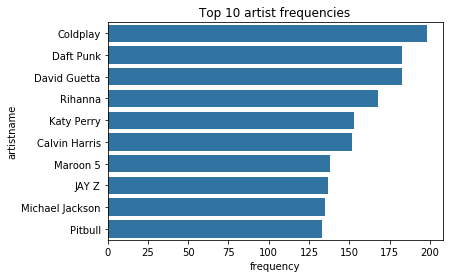

In [13]:
top_10 = unq_play.sort_values(by = 'playlistname', ascending = False)[:10]
f, ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(y="artistname", x="playlistname", data=top_10, orient = 'h', color = '#1f77b4')
ax.set(xlabel = 'frequency', title = 'Top 10 artist frequencies')

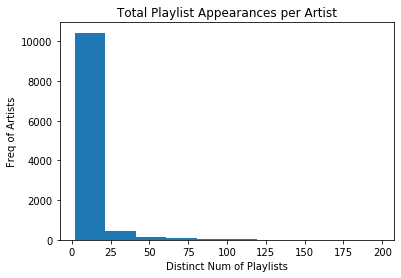

In [14]:
plt.hist(unq_play[(unq_play['playlistname'] > 1)]['playlistname'], bins=10)
plt.xlabel('Distinct Num of Playlists')
plt.ylabel('Freq of Artists')
plt.title('Total Playlist Appearances per Artist')
plt.savefig('playlistapp')

In [15]:
# same def as quarter 1
def read_edge(gph, n0, n1):
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1
        return gph[n0][n1]['weight']
    else:
        gph.add_edge(n0, n1, weight=1)
        return 1

In [16]:
%%time
G = nx.Graph()
# if not unique, could weight the number of times the artist appears in that playlist
df2_grp = df2.groupby('playlistname').agg({'artistname': lambda x: (x).unique()})

for i in range(len(df2_grp)):
    
    for a in (df2_grp.iloc[i]):
        for a1, a2 in itertools.combinations(a, 2):
            read_edge(G, a1, a2)


CPU times: user 4.21 s, sys: 97 ms, total: 4.31 s
Wall time: 4.32 s


In [17]:
# threshold = 1
# long_edges = list(filter(lambda e: e[2] <= threshold, (e for e in G.edges.data('weight'))))
# G.remove_edges_from(long_edges)

CPU times: user 39.7 s, sys: 523 ms, total: 40.2 s
Wall time: 40.2 s


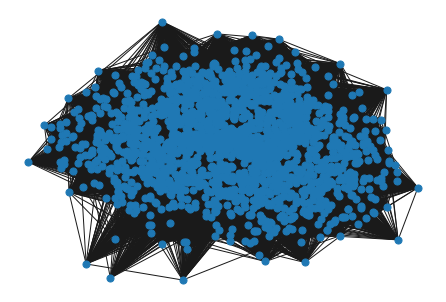

In [18]:
%%time
nx.draw(G, node_size=50)


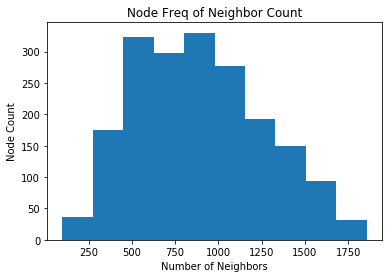

In [19]:
# [n for n in G.neighbors]
neighbors = []
for i in G.nodes:
    count = 0
    for k in G.neighbors(i):
        count += 1
    neighbors.append(count)
neigh_df = pd.DataFrame(G.nodes)
neigh_df['neighbors'] = neighbors
neigh_df
plt.hist(neigh_df['neighbors'])
plt.xlabel('Number of Neighbors')
plt.ylabel('Node Count')
plt.title('Node Freq of Neighbor Count')
plt.savefig('node_freq')

In [20]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Vampire Weekend' in i:
        weight_dict[i] = node_weights[i]

In [21]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

[(('MGMT', 'Vampire Weekend'), 29),
 (('Vampire Weekend', 'Arctic Monkeys'), 28),
 (('Daft Punk', 'Vampire Weekend'), 26),
 (('Phoenix', 'Vampire Weekend'), 25),
 (('Two Door Cinema Club', 'Vampire Weekend'), 25),
 (('Passion Pit', 'Vampire Weekend'), 24),
 (('Vampire Weekend', 'Arcade Fire'), 23),
 (('Vampire Weekend', 'The Strokes'), 23),
 (('Coldplay', 'Vampire Weekend'), 22),
 (('The Killers', 'Vampire Weekend'), 22),
 (('Kings Of Leon', 'Vampire Weekend'), 22),
 (('The Black Keys', 'Vampire Weekend'), 21),
 (('The xx', 'Vampire Weekend'), 20),
 (('Foster The People', 'Vampire Weekend'), 20),
 (('Florence + The Machine', 'Vampire Weekend'), 20),
 (('Kanye West', 'Vampire Weekend'), 20),
 (('Bloc Party', 'Vampire Weekend'), 19),
 (('Franz Ferdinand', 'Vampire Weekend'), 19),
 (('The National', 'Vampire Weekend'), 19),
 (('Vampire Weekend', 'Beck'), 19),
 (('Vampire Weekend', 'LCD Soundsystem'), 19),
 (('Vampire Weekend', 'M.I.A.'), 19),
 (('Disclosure', 'Vampire Weekend'), 18),
 (('

In [22]:
len(G.nodes)

1907

In [23]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def get_artist_genres(artist_names):
    client_id = '8ac5bd4f29854a4abb37648a5b7833d8'
    client_secret = 'c9f1281a0f774d97ae7d002139e53049'
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    artist_dict = {}
    
    for artist in artist_names:
        result = sp.search(artist, type='artist')['artists']['items']
        if len(result) > 0:
            artist_dict[artist] = result[0]['genres']
    return artist_dict


In [24]:
genres = get_artist_genres(list(G.nodes))

In [27]:
# genres

In [ ]:
## algorithm work

A = nx.to_numpy_array(G)

def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, C, iterations = 100):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)

    for n in range(iterations):
        for person in range(N):
            grad = gradient(F, A, person)

            F[person] += 0.005*grad

            F[person] = np.maximum(0.001, F[person]) # F should be nonnegative
        ll = log_likelihood(F, A)
    return F, log_likelihood(F, A)

# collect count of each genre
genres_count = {val: genres_list.count(val) for val in set(genres_list)}


In [ ]:
# perform bigclam algorithm
F, ll = train(A, 3)
pred = np.argmax(F, 1)

nodes = list(G.nodes())
one = [nodes[i] for i in np.where(pred == 0)[0]]
two = [nodes[i] for i in np.where(pred == 1)[0]]
three = [nodes[i] for i in np.where(pred == 2)[0]]

# if any of the artists have at least one shared genre within the 
# community it is considerd correct prediction
def correct_pred(pred, genres, nodes):
    total = 0
    for i in range(len(pred)):
        for j in range(len(pred)):
            if i != j:
                if len(set(genres[pred[i].lower()]).intersection(set(genres[pred[j].lower()]))) > 0:
                    total += 1
                    break
    return total

total = 0
for i in [one, two, three]:
    total += correct_pred(i, genres, nodes)
    
accuracy(total/len(nodes))

nx.draw(G, node_size=50, node_color = pred)
